# Assignment 2: CRF sequence tagging for Move Queries

# 4. Using POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [44]:
#libraries imported
import os
import sys
import pandas as pd
from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [45]:
#installing python-crfsuite 
!pip install nltk python-crfsuite scikit-learn
import pycrfsuite

In [46]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [47]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [48]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [49]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


In [50]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

#two null list is created to store the finded values
    g=[]
    h=[]
#create loop to store and append the list(example)
    for i in example:
        a = i[0]
        b = i[1]
        g.append(a)
        h.append(b)
    #a postagger for use in exercises
    posttagger = CRFTagger()
    #loading the file into the program
    posttagger.set_model_file("crf_pos.tagger")
    
    #tag a posttagger to a list
    #use a special character to split between data
    c=posttagger.tag((g))
    d=['~!'.join(z) for z in c]
    
    #using zip function zip and concatenate the list 
    r = [(k,n) for k, n in zip(d, h)]
    preprocessed_example = r  # trivial- no preprocessing
    #return preprocessed_example
    return preprocessed_example

In [51]:
testData = []
trainData = []
def splitData(percentage):
    # A method to split the data between trainData and testData 
    dataSamples = len(raw_training_data)
    #to find half of data
    halfOfData = int(len(raw_training_data)/2)
    #finding training samples
    trainingSamples = int((percentage*dataSamples)/2)
    #splitting of trainData
    for (Text) in raw_training_data[:trainingSamples] + raw_training_data[halfOfData:halfOfData+trainingSamples]:
        trainData.append(Text)
    #splitting of testData
    for (Text) in raw_training_data[trainingSamples:halfOfData] + raw_training_data[halfOfData+trainingSamples:]:
        testData.append(Text)
#80% of trainData and 20% of testData
splitData(0.8)
#print the size of trainData and testData
print(len(trainData), len(testData))

7820 1955


In [52]:
training_data = [preProcess(example) for example in raw_training_data]

In [53]:
# check the effect of pre-processing
print(training_data[0])

[('what~!WP', 'O'), ('movies~!VBZ', 'O'), ('star~!NNP', 'O'), ('bruce~!NNP', 'B-ACTOR'), ('willis~!NNP', 'I-ACTOR')]


In [54]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    
    #using split as the features 
    #intializing a posttag list
    postag=[]
    #splitting is done using splitfunction
    token,postag =token.split('~!')

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    #adding a extra suffix up to the length
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])
        
    feature_list.append("WORD_" + token)
    #append the list of postag to a new tag
    feature_list.append("postag_" + postag)
    #print(feature_list)
    return feature_list

In [55]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")
test_data = testData

training tagger...
done


In [56]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [57]:
print("testing tagger...")
preds = []
y_test = []

for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")           


testing tagger...
done


In [58]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.77      0.88      0.82       812
      B-CHARACTER       0.74      0.29      0.42        90
       B-DIRECTOR       0.78      0.63      0.70       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.61      0.47      0.53       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.88      0.82      0.85       451
         B-REVIEW       0.00      0.00      0.00        56
           B-SONG       0.71      0.22      0.34        54
          B-TITLE       0.61      0.55      0.58       562
        B-TRAILER       0.81      0.83      0.82        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.76      0.89      0.82       862
      I-CHARACTER       0.68      0.31      0.42        75
       I-DIRECTOR       0.79      0.62      0.70       496
          I-GENRE       0.84      0.70      0.76       

In [59]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

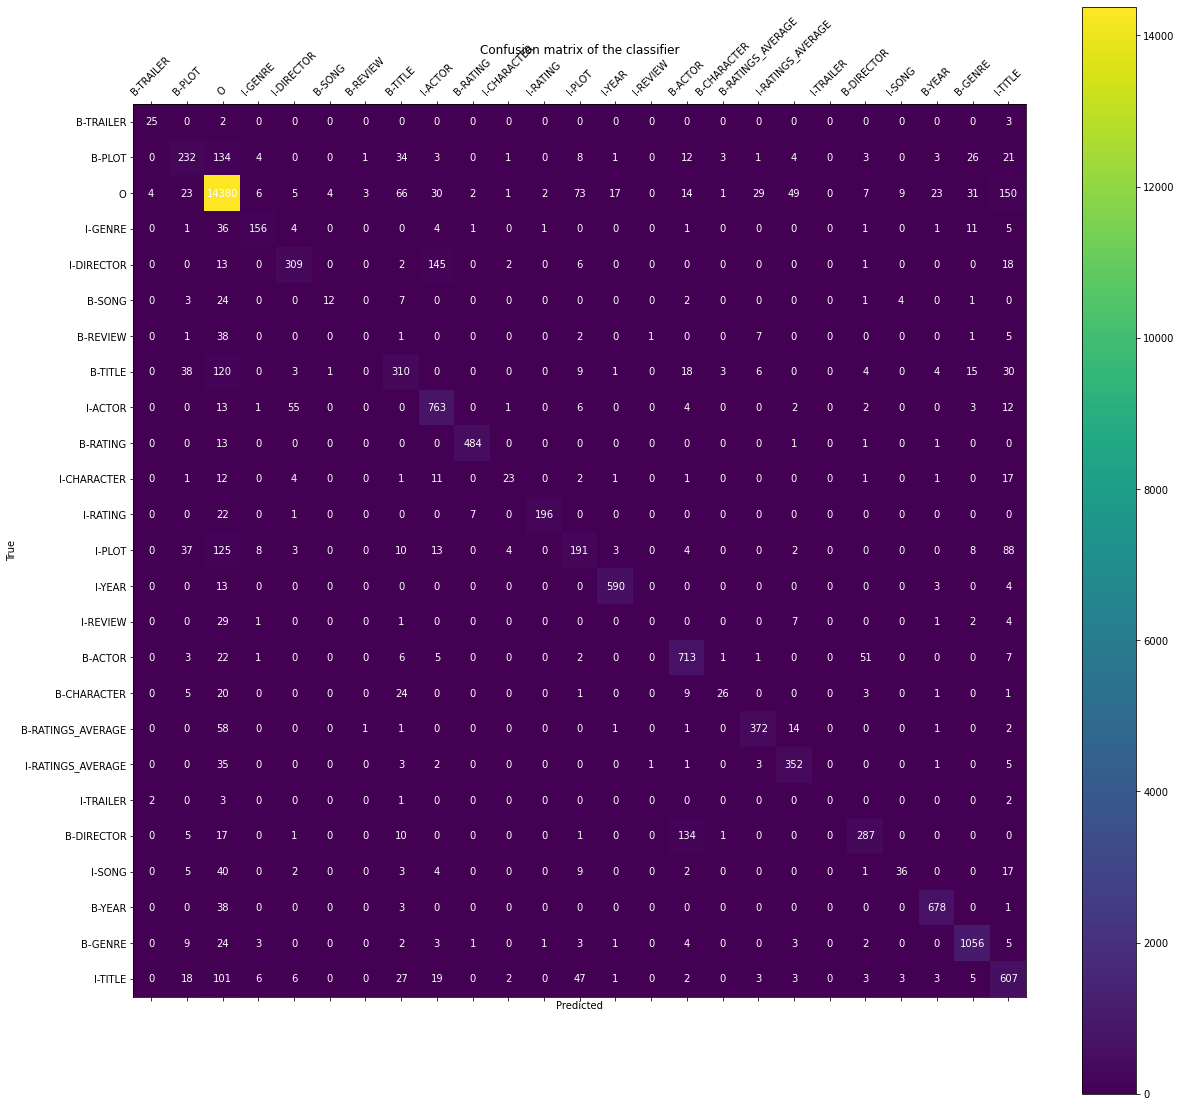

In [60]:
confusion_matrix_heatmap(y_test, preds)